# Sentiment Analysis on Tweets using VADER and Transformers

This notebook applies two different approaches to sentiment analysis on a sample of 500 tweets:

1. **Lexicon-based approach** using VADER (Valence Aware Dictionary and sEntiment Reasoner)
2. **Machine learning approach** using a pre-trained Transformers pipeline (Hugging Face)

The objective is to analyse the sentiment polarity (positive, negative, neutral) of the tweets and compare the results of the two methods.


In [16]:
# Step 1: Import libraries
import pandas as pd
import nltk
import matplotlib.pyplot as plt

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##Load the Dataset

We use the `tweets-data.csv` file provided in the assignment. The dataset contains a column named `content` which includes raw tweet text.

We randomly sample 500 tweets to keep the processing efficient and focused.


In [17]:
# Step 2: Load the dataset
df = pd.read_csv('/content/tweets-data.csv')
df = df.sample(n=500, random_state=42)  # On prend un échantillon aléatoire de 500
df.head()


,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweets,hashtag
2899,897,2023-06-25 11:06:23+00:00,2,NaN,Le #DessinDePresse de Sanaga : ls sont morts c...,titan
594,594,2023-06-25 18:23:19+00:00,0,NaN,#Russia #Wagner #RussiaCivilWar https://t.co/P...,wagner
2870,868,2023-06-25 11:32:00+00:00,1,NaN,Exclusive content -https://t.co/oEiSIIB2Z1\n.\...,titan
52,52,2023-06-25 19:11:12+00:00,21,NaN,Auch heute geht die politische Nachricht des T...,wagner
1391,390,2023-06-25 16:21:52+00:00,1,NaN,@crazyclipsonly Same type that would take a ho...,titanic


##Preprocessing and Cleaning

The tweet text is cleaned by:
- Converting to lowercase
- Removing URLs, punctuation, and digits
- Removing common English stopwords
- Token filtering by word length

This preprocessing ensures that irrelevant noise is removed before sentiment analysis.


In [18]:
# Step 3: Clean tweets
import re
import nltk # Import nltk in this cell
from nltk.corpus import stopwords

# Check if df exists before proceeding
if 'df' not in globals():
    print("Please run the previous cell (Step 2: Load the dataset) to load the dataframe 'df'.")
else:
    nltk.download('stopwords') # Download stopwords after importing nltk

    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        # Ensure the input is a string, handle potential NaN values
        text = str(text) if isinstance(text, (str, float)) else ""
        text = text.lower()
        text = re.sub(r"http\S+|www.\S+", "", text)      # liens
        text = re.sub(r"[^a-z\s]", "", text)             # ponctuation
        tokens = text.split()
        tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
        return " ".join(tokens)

    df['clean_text'] = df['Tweets'].apply(clean_text)
    display(df[['Tweets', 'clean_text']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Tweets,clean_text
2899,Le #DessinDePresse de Sanaga : ls sont morts c...,dessindepresse sanaga sont morts comme ils ont...
594,#Russia #Wagner #RussiaCivilWar https://t.co/P...,russia wagner russiacivilwar
2870,Exclusive content -https://t.co/oEiSIIB2Z1\n.\...,exclusive content cosplay japan titan titanics...
52,Auch heute geht die politische Nachricht des T...,auch heute geht die politische nachricht des t...
1391,@crazyclipsonly Same type that would take a ho...,crazyclipsonly type would take homemade playst...


##Sentiment Analysis with VADER

VADER is a rule-based sentiment analysis tool specifically tuned for social media text.

We use the `SentimentIntensityAnalyzer` from the `nltk` package to compute:
- A compound score between -1 and 1
- A categorical label: **positive**, **neutral**, or **negative**


In [19]:
# Step 4: Sentiment Analysis with VADER
vader = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = vader.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        sentiment = 'positive'
    elif compound <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return pd.Series([sentiment, compound])

df[['vader_sentiment', 'vader_score']] = df['clean_text'].apply(vader_sentiment)
display(df[['clean_text', 'vader_sentiment', 'vader_score']].head())

,clean_text,vader_sentiment,vader_score
2899,dessindepresse sanaga sont morts comme ils ont...,positive,0.4767
594,russia wagner russiacivilwar,neutral,0.0000
2870,exclusive content cosplay japan titan titanics...,negative,-0.4404
52,auch heute geht die politische nachricht des t...,negative,-0.5994
1391,crazyclipsonly type would take homemade playst...,neutral,0.0000


##Sentiment Analysis using Transformers

We also apply a **pre-trained transformer model** from the `transformers` library (by Hugging Face) to perform sentiment classification.

This method uses a fine-tuned model to directly predict the sentiment label and confidence score.


In [20]:
# Step 5: Sentiment Analysis using Transformers
!pip install -q transformers

from transformers import pipeline

model = pipeline("sentiment-analysis")

def transformer_sentiment(text):
    # Ensure text is a string
    text = str(text)

    # Pass truncation=True to the pipeline call
    result = model(text, truncation=True)[0]
    return pd.Series([result['label'].lower(), result['score']])

df[['transformer_sentiment', 'transformer_score']] = df['clean_text'].apply(transformer_sentiment)
display(df[['clean_text', 'transformer_sentiment', 'transformer_score']].head())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


,clean_text,transformer_sentiment,transformer_score
2899,dessindepresse sanaga sont morts comme ils ont...,negative,0.989421
594,russia wagner russiacivilwar,negative,0.962062
2870,exclusive content cosplay japan titan titanics...,negative,0.961531
52,auch heute geht die politische nachricht des t...,negative,0.979176
1391,crazyclipsonly type would take homemade playst...,negative,0.991605


##Comparison of VADER vs Transformers

We compare the results of both approaches using:
- A crosstab of sentiment categories
- A bar plot of sentiment distribution

This highlights the differences in classification between the lexicon-based and machine learning methods.


In [21]:
# Step 6: Compare results
pd.crosstab(df['vader_sentiment'], df['transformer_sentiment'], rownames=['VADER'], colnames=['Transformers'])


Transformers,negative,positive
VADER,,
negative,94,10
neutral,215,63
positive,79,39


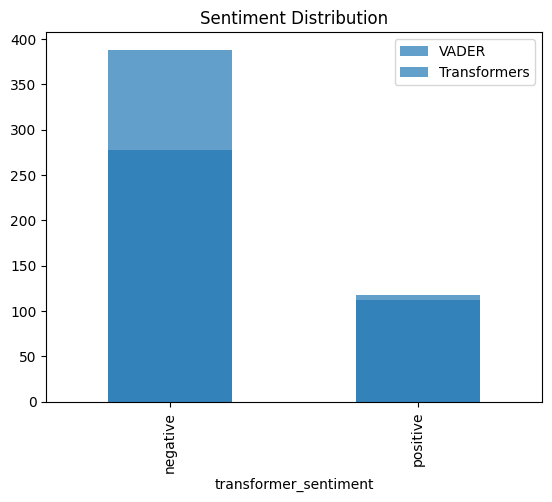

In [22]:
df['vader_sentiment'].value_counts().plot(kind='bar', alpha=0.7, label='VADER')
df['transformer_sentiment'].value_counts().plot(kind='bar', alpha=0.7, label='Transformers')
plt.title('Sentiment Distribution')
plt.legend()
plt.show()


## Conclusion

- VADER provides quick and interpretable results using lexical rules, suitable for short texts like tweets.
- Transformers offer more powerful, context-aware sentiment predictions, but require more computation.

Both methods are useful and complementary depending on the context of use.
